# Import and upload data

Autoregressive model is an active approach in image generation field. The intuition behind this is that model tries to predict a value of new pixel based on its previous prediction. In this kind of field, we assume that the value of some specific pixels depend on the previous ones. For instance, if you are trying to reconstruct an orange image, then if there is *orange* pixel at pixel $p$, then probability for pixel in $p+1$ as *orange* should be high since image of an orange mostly contains many orange pixels in a round region.

Two popular neural networks which are used for this approach are Convolution Neural Network (CNN) and Recurrent Neural Network (RNN) as mentioned in this [article](https://arxiv.org/pdf/1601.06759).
- PixelRNN tries to predict new value pixel by pixel , row by row based on recurrence relationship. This method is straightforward for our assumption about the conditional probability.
- PixelCNN can be considered as an alternative for PixelRNN since its parallelization in training phase. However, the standard CNN has a convolutional filter collecting the information of current pixel and also future pixels, which might result in "cheating" in CNN. To avoid this, __Masking__ technique is applied to "hide" network from seeing the future pixel values.

There are 2 main type of masking:
- Mask type A which masks the current value of pixel (and future pixels), which is only applied at the beginning of NN
- Mask type B only masks future pixels and let NN see the current value of future maps, which is applied for the rest of training

In this notebook we use MNIST data set which contains 60k images of 28x28 pixels. Each pixel have only one dimension which represents for gray scale. For simplicity, rescale is applied and covert them to binary pixel - 0 for white and 1 for black

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.activations import relu
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')


In [ ]:
(ds_train, ds_test), ds_info = tfds.load('mnist',
                              split=['test', 'test'],
                              shuffle_files=True,
                              as_supervised=True,
                              with_info=True)

#fig = tfds.show_examples(ds_info, ds_train)

def binarize(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.math.round(image/255.)
    return image, tf.cast(image, tf.int32)  # cast to binary

ds_train = ds_train.map(binarize)
ds_train = ds_train.cache() # put dataset into memory
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(64)
ds_test = ds_test.map(binarize).batch(64).cache().prefetch(64)

# Implement a custom layer

- Construct masked convolution layers
- Construct residual block using 3 convolution layers. Use padding = "same" and stride = 1 to preserve the dimension of inputs

In [ ]:
class MaskedConv2D (tf.keras.layers.Layer):
  def __init__(self, kernel, filters, mask_type):
    super(MaskedConv2D, self).__init__()
    self.kernel = kernel
    self.filters = filters
    self.mask_type = mask_type

  def build(self, input_shape):
    self.w = self.add_weight(shape = [self.kernel, # filter size
                                      self.kernel,
                                      input_shape[-1],  # channel to element-wise conv
                                      self.filters],
                             initializer = 'glorot_normal',
                             trainable = True)
    self.b = self.add_weight(shape = (self.filters),
                             initializer = 'zeros',
                             trainable = True)

    mask = np.ones(self.kernel**2, dtype = np.float32)
    center = len(mask) // 2
    mask[center + 1:] = 0

    if self.mask_type == 'A':
      mask[center] = 0
    mask = mask.reshape((self.kernel, self.kernel, 1, 1))
    self.mask = tf.constant(mask, dtype = 'float32')

  def call(self, inputs):
    masked_w = tf.math.multiply(self.mask, self.w)
    output = tf.nn.conv2d(inputs, masked_w, 1, "SAME") + self.b # padding = 'same', stride = 1 -> using padding such that the output dimension is the same
                                                                # with stride > 1 -> lower dimension
    return output

In [ ]:
class ResidualBlock(layers.Layer):
  def __init__(self, h= 32):
    super(ResidualBlock, self).__init__()
    self.resblock = Sequential([
        MaskedConv2D(kernel = 1, filters = h, mask_type = "B"),
        MaskedConv2D(kernel = 3, filters = h, mask_type = "B"),
        MaskedConv2D(kernel = 1, filters = 2*h, mask_type = "B")
    ])

  def call(self, inputs):
    output = self.resblock(inputs)
    return inputs + output


In [ ]:
def SimplePixelCNN(hidden_dims = 64, output_dims = 1, res_num = 7):
  model = Sequential()
  model.add(InputLayer(input_shape = (28, 28, 1)))
  model.add(MaskedConv2D(7, 2*hidden_dims, "A"))

  for _ in range(res_num):
    model.add(ResidualBlock(hidden_dims))

  model.add(Conv2D(hidden_dims, 1, (1,1), padding = 'same', activation = 'relu'))
  model.add(Conv2D(output_dims, 1, (1,1), padding = 'same', activation = 'sigmoid'))

  return model

In [ ]:
pixelcnn = SimplePixelCNN()
pixelcnn.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masked_conv2d_90 (MaskedCon  (None, 28, 28, 128)      6400      
 v2D)                                                            
                                                                 
 residual_block_28 (Residual  (None, 28, 28, 128)      53504     
 Block)                                                          
                                                                 
 residual_block_29 (Residual  (None, 28, 28, 128)      53504     
 Block)                                                          
                                                                 
 residual_block_30 (Residual  (None, 28, 28, 128)      53504     
 Block)                                                          
                                                                 
 residual_block_31 (Residual  (None, 28, 28, 128)    

In [ ]:
pixelcnn.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate = 0.001),
                 loss = tf.keras.losses.BinaryCrossentropy(),
                 metrics = [tf.keras.losses.BinaryCrossentropy()])

pixelcnn.fit(ds_train, epochs = 20, validation_data = ds_test)

Epoch 1/20
157/157 [==============================] - 19s 74ms/step - loss: 0.1774 - binary_crossentropy: 0.1771 - val_loss: 0.1142 - val_binary_crossentropy: 0.1142
Epoch 2/20
157/157 [==============================] - 11s 72ms/step - loss: 0.1096 - binary_crossentropy: 0.1095 - val_loss: 0.1062 - val_binary_crossentropy: 0.1062
Epoch 3/20
157/157 [==============================] - 11s 72ms/step - loss: 0.1017 - binary_crossentropy: 0.1016 - val_loss: 0.0980 - val_binary_crossentropy: 0.0980
Epoch 4/20
157/157 [==============================] - 14s 87ms/step - loss: 0.0987 - binary_crossentropy: 0.0987 - val_loss: 0.0993 - val_binary_crossentropy: 0.0993
Epoch 5/20
157/157 [==============================] - 11s 72ms/step - loss: 0.0966 - binary_crossentropy: 0.0965 - val_loss: 0.0942 - val_binary_crossentropy: 0.0942
Epoch 6/20
157/157 [==============================] - 11s 72ms/step - loss: 0.0950 - binary_crossentropy: 0.0949 - val_loss: 0.0931 - val_binary_crossentropy: 0.0931
Epoc

# Generate a whole new image of digital character from a totally white image

In [ ]:
grid_row = 5
grid_col = 5
batch = grid_row * grid_col
h = w = 28
images = np.ones((batch,h,w,1), dtype=np.float32)

for row in range(h):

    for col in range(w):

        prob = pixelcnn.predict(images)[:,row,col,0]

        pixel_samples = tf.random.categorical(tf.math.log(np.stack([1-prob, prob],1)), 1)

        images[:,row,col,0] = tf.reshape(pixel_samples,[batch])

1/1 [==============================] - 0s 21ms/step


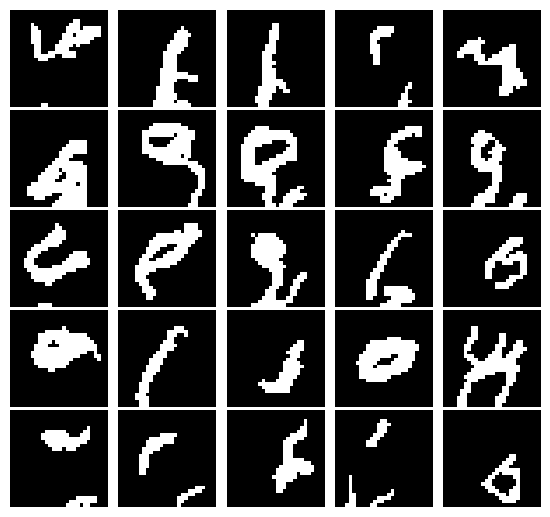

In [ ]:
# Display
f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1,grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')
        i += 1
f.tight_layout(pad = 0.1, h_pad=0.2, w_pad=0.1)
plt.show()